In [1]:
import networkit as nk
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np

In [2]:

graph = nk.graphio.EdgeListReader(",",0).read("./musae_git_edges.csv")
nxgraph = nk.nxadapter.nk2nx(graph)

In [3]:
loopedGraph = graph
graph.removeSelfLoops()

In [4]:
clf = nk.centrality.LocalClusteringCoefficient(graph)

In [5]:
clf.run()
nkglob = np.mean(clf.scores())

nxglob = nx.cluster.average_clustering(nxgraph)
print(nxglob)
print(nkglob)

0.16753704480107237
0.16753704480107584


(array([4.93872679, 2.07718833, 1.14827586, 0.7928382 , 0.23183024,
        0.21671088, 0.19124668, 0.00928382, 0.02413793, 0.36976127]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

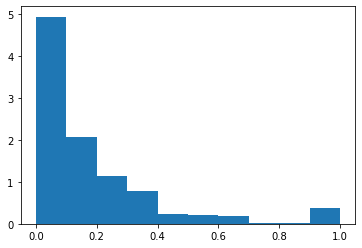

In [6]:
plt.hist(clf.scores(),density=True)

In [7]:
triadic_c = nx.triangles(nxgraph)


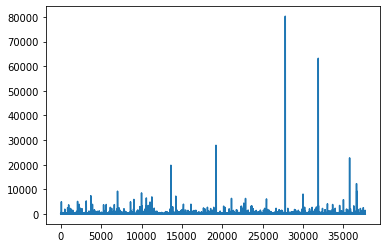

(array([3.7689e+04, 6.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0. ,  8028.6, 16057.2, 24085.8, 32114.4, 40143. , 48171.6,
        56200.2, 64228.8, 72257.4, 80286. ]),
 <BarContainer object of 10 artists>)

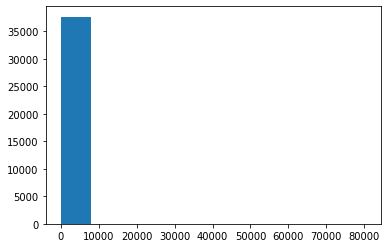

In [8]:
plt.plot(triadic_c.keys(),triadic_c.values())
plt.show()
plt.hist(triadic_c.values())

(array([2.88862e+05, 1.01000e+02, 2.20000e+01, 9.00000e+00, 6.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([   0. ,  241.1,  482.2,  723.3,  964.4, 1205.5, 1446.6, 1687.7,
        1928.8, 2169.9, 2411. ]),
 <BarContainer object of 10 artists>)

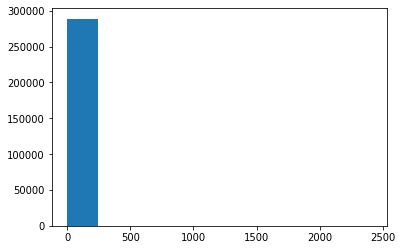

In [9]:
algo = nk.sparsification.TriangleEdgeScore(graph)
graph.indexEdges()
algo.run()
plt.hist(algo.scores())

In [10]:
communities = nk.community.detectCommunities(graph)

Communities detected in 0.05984 [s]
solution properties:
-------------------  -------------
# communities            22
min community size        3
max community size     7348
avg. community size    1713.64
imbalance                 4.28705
edge cut             113360
edge cut (portion)        0.392245
modularity                0.453517
-------------------  -------------


/home/drfaust/.local/lib/python3.10/site-packages/networkit/stopwatch.py:49: UserWarning: networkit.Timer is deprecated, will be removed in future updates.
  warn("networkit.Timer is deprecated, will be removed in future updates.")


In [11]:
nxcomms = nx.community.louvain_communities(nxgraph)
partitions = nx.community.louvain_partitions(nxgraph)

(array([22.,  1.,  2.,  0.,  1.,  1.,  0.,  1.,  0.,  1.]),
 array([3.0000e+00, 1.0045e+03, 2.0060e+03, 3.0075e+03, 4.0090e+03,
        5.0105e+03, 6.0120e+03, 7.0135e+03, 8.0150e+03, 9.0165e+03,
        1.0018e+04]),
 <BarContainer object of 10 artists>)

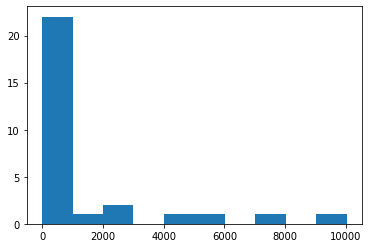

In [12]:
sizes = [len(com) for com in nxcomms]
plt.hist(sizes)


In [20]:
pos = nx.spring_layout(nxgraph,seed=255)

nx.draw(nxcomms[1],pos)

KeyboardInterrupt: 